<a href="https://colab.research.google.com/github/SistemasOperativosAvanz/hpc-tp-3/blob/main/Ejercicio1/Cuaderno_1_Miercoles_grupo10_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size ="+2"> 1 Introducción </font>

El siguiente ejemplo ilustra el comportamiento de un filtro de pase alto (High pass filter) que hace referencia a atenuar los componentes con una "frecuencia" baja, mientras que los componentes de alta frecuencia no se ven afectados.

(Esto es en el caso que trabajemos con un espectro de frecuencias, con respecto al trabajo con imágenes el filtro es aplicado a los píxeles de la imagen respectiva)

Con respecto a la imagen, su implementación es similar a pasar una imagen a escala de grises, pero solamente modificando aquellos píxeles que no superen cierto umbral. 



<font size ="+2"> 2 Armado del ambiente </font>

Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno colab.

In [1]:
#@title # 2.1 Parametros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen =  "https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/sampleImageGrayscale.jpg?raw=true" #@param {type:"string"}

#@markdown ---
#!wget https://resizer.glanacion.com/resizer/Wt7c9G_TCewfo1JU_YQh38ygBRY=/768x0/filters:quality(80)/cloudfront-us-east-1.images.arcpublishing.com/lanacionar/BPZX5263MZDBFNHZDVZ5BLP73Y.jpg -O imagen.jpg

!wget {url_imagen} -O imagen.jpg

--2021-11-28 17:53:48--  https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/sampleImageGrayscale.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SistemasOperativosAvanz/hpc-tp-3/raw/main/sampleImageGrayscale.jpg [following]
--2021-11-28 17:53:49--  https://github.com/SistemasOperativosAvanz/hpc-tp-3/raw/main/sampleImageGrayscale.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SistemasOperativosAvanz/hpc-tp-3/main/sampleImageGrayscale.jpg [following]
--2021-11-28 17:53:49--  https://raw.githubusercontent.com/SistemasOperativosAvanz/hpc-tp-3/main/sampleImageGrayscale.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

<font size="+2"> 3 - Desarrollo CPU </font>

Código que resuelve el ejercicio desde el punto de vista secuencial. A partir de una imagen en escala de grises, debemos recorrer píxel por píxel, utilizando el algoritmo especificado a continuación: 

![image.png](https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/imageConvolutionExample.JPG?raw=true)

Estando ubicados en un píxel en particular, se obtienen los elementos adyacentes a éste (los píxeles adyacentes al píxel actual), formando una matriz de 3x3 (En este caso al ser RGB, se forma una matriz por cada color, ósea rojo, verde y azul).

Las matrices de 3x3 (Rojo, verde y azul respectivamente) realizan un producto elemento por elemento con una matriz definida que es la siguiente: 

              [-1, -1, -1]
              [-1,  9, -1]
              [-1, -1, -1]

que se utiliza para el filtro especificado (High Pass Filter). 
Luego de obtener el resultado del producto elemento por elemento, se realiza la sumatoria de las matrices resultantes. Este valor se compara contra un umbral ya predefinido. En caso de sobrepasar este umbral, el píxel obtiene el valor de la sumatoria de la matriz resultante. Caso contrario, el píxel obtiene por resultado el mismo valor que tenía antes de realizar el algoritmo, pero con una atenuación (resta) de su valor.


Imagen del filtro: imagen.jpg -RGB- [1076, 720]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tiempo de ejecución CPU:  90445.264 [ms]
Tiempo Total:  90537.248 [ms]


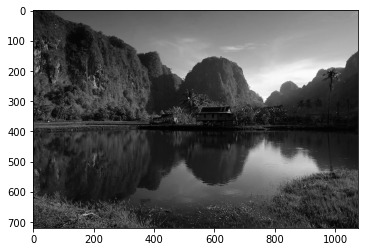

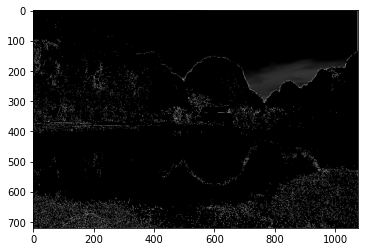

In [6]:
from datetime import datetime

tiempo_total_cpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre)

# Obtengo las dimensiones de la imagen
img_ancho, img_alto = image.size

# Convierto la imagen comprimida en JPEG/PNG a array.
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_R_cpu = numpy.empty_like( img_O_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_O_cpu )

tiempo_cpu = datetime.now()
 
matHPF = [[-1, -1, -1], [-1,9,-1], [-1,-1,-1]]
umbral = 400
atenuacionPixel = 200

for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):

    matAuxRojo = [[0, 0, 0], [0,0,0], [0,0,0]]
    matAuxVerde = [[0, 0, 0], [0,0,0], [0,0,0]]
    matAuxAzul = [[0, 0, 0], [0,0,0], [0,0,0]]

    sumaRojo = 0
    sumaVerde = 0
    sumaAzul = 0

    i = 0
    j = 0
    auxI = 0
    auxJ = 0

    if y - 1 >= 0 and x - 1 >= 0:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y-1)][(x-1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1
    
    if y - 1 >= 0:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y-1)][x]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1

    if y - 1 >= 0 and x + 1 < img_ancho:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y-1)][(x+1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ = 0
    auxI += 1

    if x - 1 >= 0:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[y][(x-1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1

    pixelRojo, pixelVerde, pixelAzul = img_O_cpu[y][x]
    matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
    matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
    matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1

    if x + 1 < img_ancho:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[y][(x+1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ = 0
    auxI += 1

    if y + 1 < img_alto and x - 1 >= 0:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y+1)][(x-1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1

    if y + 1 < img_alto:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y+1)][x]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ += 1

    if y + 1 < img_alto and x + 1 < img_ancho:
      pixelRojo, pixelVerde, pixelAzul = img_O_cpu[(y+1)][(x+1)]
      matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * pixelRojo
      matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * pixelVerde
      matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * pixelAzul
    auxJ = 0
    auxI += 1

    for i in range(0,3):
      for j in range(0,3):
        sumaRojo += matAuxRojo[i][j]
        sumaVerde += matAuxVerde[i][j]
        sumaAzul += matAuxAzul[i][j]

    pixelRojo, pixelVerde, pixelAzul = img_O_cpu[y][x]
      
    if sumaRojo > umbral:
      pixelRojo = sumaRojo
      img_R_cpu[y][x] = [sumaRojo, pixelVerde, pixelAzul]
    else:
      pixelRojo = pixelRojo - atenuacionPixel
      img_R_cpu[y][x] = [pixelRojo, pixelVerde, pixelAzul]

    if sumaVerde > umbral:
      pixelVerde = sumaVerde
      img_R_cpu[y][x] = [pixelRojo, sumaVerde, pixelAzul]
    else:
      pixelVerde = pixelVerde - atenuacionPixel
      img_R_cpu[y][x] = [pixelRojo, pixelVerde, pixelAzul]
      
    if sumaAzul > umbral:
      pixelAzul = sumaAzul
      img_R_cpu[y][x] = [pixelRojo, pixelVerde, sumaAzul]
    else:
      pixelAzul = pixelAzul - atenuacionPixel
      img_R_cpu[y][x] = [pixelRojo, pixelVerde, pixelAzul]



tiempo_cpu = datetime.now() - tiempo_cpu

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_R_cpu )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu

print( "Tiempo de ejecución CPU: ", tiempo_en_ms( tiempo_cpu   ), "[ms]" )
print( "Tiempo Total: ",            tiempo_en_ms( tiempo_total_cpu ), "[ms]" )




<font size = "+2"> 4.1 Instala en el cuaderno el módulo CUDA de Python. </font>

In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 3.9 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627577 sha256=f48865660d9657d7ea449feaf100153ce57adf690f177eaa6496d7d50d08f858
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=cc03bb69b9d31787b7d25e33af1158a9cb8fdd81f15c425bb76953854ef54dac
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


<font size="+2"> 4.2 - Desarrollo GPU </font>

Código que resuelve el ejercicio desde el punto de vista paralelo (utilizando GPU). A partir de una imagen en escala de grises, debemos recorrer píxel por píxel, utilizando el algoritmo especificado a continuación: 

![image.png](https://github.com/SistemasOperativosAvanz/hpc-tp-3/blob/main/imageConvolutionExample.JPG?raw=true)

Estando ubicados en un píxel en particular, se obtienen los elementos adyacentes a éste (los píxeles adyacentes al píxel actual), formando una matriz de 3x3 (En este caso al ser RGB, se forma una matriz por cada color, ósea rojo, verde y azul).

Las matrices de 3x3 (Rojo, verde y azul respectivamente) realizan un producto elemento por elemento con una matriz definida que es la siguiente: 

              [-1, -1, -1]
              [-1,  9, -1]
              [-1, -1, -1]

que se utiliza para el filtro especificado (High Pass Filter). 
Luego de obtener el resultado del producto elemento por elemento, se realiza la sumatoria de las matrices resultantes. Este valor se compara contra un umbral ya predefinido. En caso de sobrepasar este umbral, el píxel obtiene el valor de la sumatoria de la matriz resultante. Caso contrario, el píxel obtiene por resultado el mismo valor que tenía antes de realizar el algoritmo, pero con una atenuación (resta) de su valor.

Obtendremos un gran rendimiento ya que este proceso se realiza en paralelo, trabajando con hilos en dos dimensiones podremos ir recorriendo píxel por píxel de la imagen original en simultáneo.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen del filtro: imagen.jpg -RGB- [1076, 720]
Thread: [ 16 , 19  ], Bloque : [ 68 , 38 ]
Total de Thread: [ 1088 , 722  ]  =  785536
Tiempo TOTAL:  481.147 [ms]
Tiempo GPU  :  0.226 [ms]


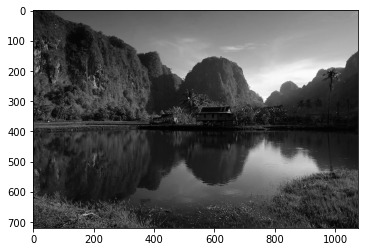

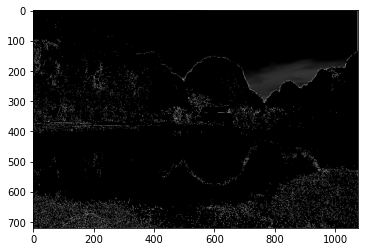

In [7]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)
# print("img_O_cpu: ", img_O_cpu)
# print("img_R_cpu: ", img_R_cpu)

try:

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  int matHPF[3][3] = {{-1, -1, -1}, {-1, 9, -1}, {-1, -1, -1}};
  int umbral = 400;
  int atenuacionPixel = 200;

  int matAuxRojo[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};
  int matAuxVerde[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};
  int matAuxAzul[3][3] = {{0,0,0}, {0,0,0}, {0,0,0}};

  int sumaRojo = 0;
  int sumaVerde = 0;
  int sumaAzul = 0;

  int i, j, auxI, auxJ;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {

    auxI = 0;
    auxJ = 0;


    for(i = idx - 1; i <= idx + 1 && i < ancho; i++)
    {

        if(i < 0)
        {
          i++;
          auxI++;
        }
          

      for(j = idy - 1; j <= idy + 1 && j < alto; j++)
      {
        if(j < 0)
        {
          j++;
          auxJ++;
        }
        

        matAuxRojo[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[(i + (j*ancho)) * 3];
        matAuxVerde[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[((i +(j*ancho))*3)+1];
        matAuxAzul[auxI][auxJ] = matHPF[auxI][auxJ] * img_O[((i +(j*ancho))*3)+2];
        auxJ++;
      }
      auxI++;
      auxJ = 0;
    }

    for(i = 0; i < 3; i++)
    {
      for(j = 0; j < 3; j++)
      {
        sumaRojo += matAuxRojo[i][j];
        sumaVerde += matAuxVerde[i][j];
        sumaAzul += matAuxAzul[i][j];
      }
    }

    if(sumaRojo > umbral)
    img_R[(idx+(idy*ancho))*3  ] = sumaRojo;
    else
    img_R[(idx+(idy*ancho))*3  ] = (img_O[(idx + (idy*ancho)) * 3]) - atenuacionPixel;

    if(sumaVerde > umbral)
    img_R[(idx+(idy*ancho))*3+1] = sumaVerde;
    else
    img_R[(idx+(idy*ancho))*3+1] = (img_O[((idx +(idy*ancho))*3)+1]) - atenuacionPixel;

    if(sumaAzul > umbral)
    img_R[(idx+(idy*ancho))*3+2] = sumaAzul;
    else
    img_R[(idx+(idy*ancho))*3+2] = (img_O[((idx +(idy*ancho))*3)+2]) - atenuacionPixel;
  }
}
""") 

  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x)

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y)

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_gpu = datetime.now()

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_gpu = datetime.now() - tiempo_gpu

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total_gpu = datetime.now() - tiempo_total_gpu

  # cuda.Context.synchronize();

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_gpu ), "[ms]" )

except Exception as e:
  print("Ha ocurrido un error.\n Recuerde que debe estar conectado a un entorno GPU y haber realizado la instalación del módulo de CUDA.\n ", e.args)






<font size="+2"> 5. Métricas </font>

Para medir los tiempos promedios entre la ejecución del filtro de paso alto (High Pass Filter) realizaremos varios ensayos, en los que observamos lo siguiente:

<center>  <font size="+1"> CPU </font> </center> 

Numero de Ensayo | Tiempo CPU | Tiempo Total
---------|--------|----------------
1 | 77740.34 [ms] | 77864.776 [ms]
2 | 77975.273 [ms] | 78055.453 [ms]
3 | 78471.737 [ms] | 78560.096 [ms]
4 | 78107.906 [ms] | 78189.57 [ms]
5 | 78822.619 [ms] | 78903.025 [ms]

 .
<center>  <font size="+1"> GPU </font> </center> 

Numero de Ensayo | Tiempo GPU | Tiempo Total
---------|--------|----------------
1 | 0.191 [ms] | 102.246 [ms]
2 | 0.089 [ms] | 116.236 [ms]
3 | 0.098 [ms] | 102.357 [ms]
4 | 0.089 [ms] | 102.022 [ms]
5 | 0.109 [ms] | 106.616 [ms]


.

Luego de realizar varias pruebas, tanto en la ejecución del algoritmo de forma secuencial y el algoritmo de forma paralela (utilizando GPU) vemos cambios significativos en la performance del mismo. Por ejemplo, podemos ilustrar:

In [8]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

diferencia_tiempo_total = tiempo_total_cpu - tiempo_total_gpu
diferencia_tiempo = tiempo_cpu - tiempo_gpu

print("Tiempo de ejecución total en CPU: ", tiempo_en_ms(tiempo_total_cpu), "[ms]")
print("Tiempo de ejecución total en GPU: ", tiempo_en_ms(tiempo_total_gpu), "[ms]\n")

print("Tiempo de ejecución en CPU: ", tiempo_en_ms(tiempo_cpu), "[ms]")
print("Tiempo de ejecución en GPU: ", tiempo_en_ms(tiempo_gpu), "[ms]\n")


print("Comparacion de Tiempo total entre CPU y GPU: ",  tiempo_en_ms(diferencia_tiempo_total), "[ms]")
print("Comparacion de Tiempo entre CPU y GPU: ",  tiempo_en_ms(diferencia_tiempo), "[ms]\n")

Tiempo de ejecución total en CPU:  90537.248 [ms]
Tiempo de ejecución total en GPU:  481.147 [ms]

Tiempo de ejecución en CPU:  90445.264 [ms]
Tiempo de ejecución en GPU:  0.226 [ms]

Comparacion de Tiempo total entre CPU y GPU:  90056.101 [ms]
Comparacion de Tiempo entre CPU y GPU:  90445.038 [ms]



<font size="+2"> 6. Conclusiones </font>

Al obtener varias muestras en la ejecución del algoritmo HPF secuencial y paralelamente (al utilizar GPU), podemos evidenciar el potencial que obtenemos utilizando GPU, brindándonos una performance más que notable. (Siendo el tiempo total más de 700 veces más rapido). 

Contamos con la necesidad de recalcar que el GPU responde a lo que el CPU le "ordena" (haciendo referencia al ejemplo en el que el CPU es el cerebro y el GPU la orquesta) y que de ninguna manera es un reemplazo para él, solo que es mucho más performante (y tiene otras capacidades) además que puede aprovecharse su potencial para muchísimos ámbitos.

<font size="+2"> 7. Bibliografía </font>

[1] High Pass Filter for image processing in python by using scipy/numpy: [Referencia](https://stackoverflow.com/questions/6094957/high-pass-filter-for-image-processing-in-python-by-using-scipy-numpy)

[2] Image Convolution for CUDA: [Referencia](https://developer.download.nvidia.com/compute/cuda/1.1-Beta/x86_64_website/projects/convolutionSeparable/doc/convolutionSeparable.pdf)

[3] GPU Image Convolution: [Referencia](https://cg.ivd.kit.edu/downloads/GPGPU_assignment_3.pdf)

